In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'relu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

relu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/80 [..............................] - ETA: 1:57 - loss: 0.1282 - STD: 0.0126 - MAE: 0.3445

 4/80 [>.............................] - ETA: 2s - loss: 0.0552 - STD: 0.0136 - MAE: 0.1967  

 5/80 [>.............................] - ETA: 2s - loss: 0.0470 - STD: 0.0153 - MAE: 0.1780

 6/80 [=>............................] - ETA: 2s - loss: 0.0413 - STD: 0.0167 - MAE: 0.1618

 7/80 [=>............................] - ETA: 3s - loss: 0.0369 - STD: 0.0182 - MAE: 0.1493

 8/80 [==>...........................] - ETA: 3s - loss: 0.0337 - STD: 0.0201 - MAE: 0.1419

 9/80 [==>...........................] - ETA: 3s - loss: 0.0310 - STD: 0.0215 - MAE: 0.1340

10/80 [==>...........................] - ETA: 3s - loss: 0.0288 - STD: 0.0228 - MAE: 0.1277

11/80 [===>..........................] - ETA: 3s - loss: 0.0271 - STD: 0.0245 - MAE: 0.1241

12/80 [===>..........................] - ETA: 3s - loss: 0.0256 - STD: 0.0255 - MAE: 0.1195

13/80 [===>..........................] - ETA: 3s - loss: 0.0243 - STD: 0.0264 - MAE: 0.1156

14/80 [====>.........................] - ETA: 3s - loss: 0.0232 - STD: 0.0275 - MAE: 0.1133

15/80 [====>.........................] - ETA: 3s - loss: 0.0222 - STD: 0.0283 - MAE: 0.1102

16/80 [=====>........................] - ETA: 5s - loss: 0.0220 - STD: 0.0290 - MAE: 0.1074

19/80 [======>.......................] - ETA: 4s - loss: 0.0197 - STD: 0.0309 - MAE: 0.1016

21/80 [======>.......................] - ETA: 4s - loss: 0.0185 - STD: 0.0321 - MAE: 0.0987

22/80 [=======>......................] - ETA: 4s - loss: 0.0180 - STD: 0.0325 - MAE: 0.0972

23/80 [=======>......................] - ETA: 4s - loss: 0.0175 - STD: 0.0330 - MAE: 0.0958

24/80 [========>.....................] - ETA: 4s - loss: 0.0171 - STD: 0.0336 - MAE: 0.0950

25/80 [========>.....................] - ETA: 3s - loss: 0.0168 - STD: 0.0340 - MAE: 0.0938

26/80 [========>.....................] - ETA: 3s - loss: 0.0164 - STD: 0.0343 - MAE: 0.0927

27/80 [=========>....................] - ETA: 3s - loss: 0.0161 - STD: 0.0349 - MAE: 0.0923

28/80 [=========>....................] - ETA: 3s - loss: 0.0159 - STD: 0.0350 - MAE: 0.0914

29/80 [=========>....................] - ETA: 3s - loss: 0.0156 - STD: 0.0352 - MAE: 0.0905

30/80 [==========>...................] - ETA: 3s - loss: 0.0154 - STD: 0.0356 - MAE: 0.0904

31/80 [==========>...................] - ETA: 3s - loss: 0.0152 - STD: 0.0357 - MAE: 0.0896

32/80 [===========>..................] - ETA: 3s - loss: 0.0150 - STD: 0.0358 - MAE: 0.0889

33/80 [===========>..................] - ETA: 3s - loss: 0.0148 - STD: 0.0361 - MAE: 0.0885

34/80 [===========>..................] - ETA: 3s - loss: 0.0145 - STD: 0.0364 - MAE: 0.0879

35/80 [============>.................] - ETA: 3s - loss: 0.0143 - STD: 0.0364 - MAE: 0.0872

36/80 [============>.................] - ETA: 2s - loss: 0.0141 - STD: 0.0366 - MAE: 0.0866

37/80 [============>.................] - ETA: 2s - loss: 0.0140 - STD: 0.0369 - MAE: 0.0863

38/80 [=============>................] - ETA: 2s - loss: 0.0138 - STD: 0.0370 - MAE: 0.0857

39/80 [=============>................] - ETA: 2s - loss: 0.0136 - STD: 0.0371 - MAE: 0.0851

40/80 [==============>...............] - ETA: 2s - loss: 0.0135 - STD: 0.0374 - MAE: 0.0847

41/80 [==============>...............] - ETA: 2s - loss: 0.0133 - STD: 0.0376 - MAE: 0.0843

42/80 [==============>...............] - ETA: 2s - loss: 0.0132 - STD: 0.0377 - MAE: 0.0838

43/80 [===============>..............] - ETA: 2s - loss: 0.0130 - STD: 0.0379 - MAE: 0.0833

44/80 [===============>..............] - ETA: 2s - loss: 0.0129 - STD: 0.0381 - MAE: 0.0830

45/80 [===============>..............] - ETA: 2s - loss: 0.0127 - STD: 0.0383 - MAE: 0.0826

46/80 [================>.............] - ETA: 2s - loss: 0.0126 - STD: 0.0385 - MAE: 0.0821

47/80 [================>.............] - ETA: 2s - loss: 0.0125 - STD: 0.0386 - MAE: 0.0817

48/80 [=================>............] - ETA: 2s - loss: 0.0124 - STD: 0.0389 - MAE: 0.0814

49/80 [=================>............] - ETA: 2s - loss: 0.0122 - STD: 0.0390 - MAE: 0.0810

50/80 [=================>............] - ETA: 1s - loss: 0.0121 - STD: 0.0391 - MAE: 0.0806

51/80 [==================>...........] - ETA: 1s - loss: 0.0120 - STD: 0.0393 - MAE: 0.0803

52/80 [==================>...........] - ETA: 1s - loss: 0.0119 - STD: 0.0395 - MAE: 0.0800

53/80 [==================>...........] - ETA: 1s - loss: 0.0118 - STD: 0.0396 - MAE: 0.0796

54/80 [===================>..........] - ETA: 1s - loss: 0.0117 - STD: 0.0397 - MAE: 0.0793

55/80 [===================>..........] - ETA: 1s - loss: 0.0116 - STD: 0.0399 - MAE: 0.0791

56/80 [====================>.........] - ETA: 1s - loss: 0.0115 - STD: 0.0400 - MAE: 0.0788

57/80 [====================>.........] - ETA: 1s - loss: 0.0115 - STD: 0.0401 - MAE: 0.0785

58/80 [====================>.........] - ETA: 1s - loss: 0.0114 - STD: 0.0402 - MAE: 0.0782

59/80 [=====================>........] - ETA: 1s - loss: 0.0113 - STD: 0.0403 - MAE: 0.0779

60/80 [=====================>........] - ETA: 1s - loss: 0.0112 - STD: 0.0404 - MAE: 0.0776

61/80 [=====================>........] - ETA: 1s - loss: 0.0111 - STD: 0.0405 - MAE: 0.0774

62/80 [======================>.......] - ETA: 1s - loss: 0.0110 - STD: 0.0406 - MAE: 0.0772

63/80 [======================>.......] - ETA: 1s - loss: 0.0110 - STD: 0.0407 - MAE: 0.0769

64/80 [=======================>......] - ETA: 1s - loss: 0.0109 - STD: 0.0409 - MAE: 0.0767

65/80 [=======================>......] - ETA: 0s - loss: 0.0108 - STD: 0.0410 - MAE: 0.0764

66/80 [=======================>......] - ETA: 0s - loss: 0.0108 - STD: 0.0411 - MAE: 0.0762

67/80 [========================>.....] - ETA: 0s - loss: 0.0107 - STD: 0.0412 - MAE: 0.0760

68/80 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 0.0413 - MAE: 0.0757

69/80 [========================>.....] - ETA: 0s - loss: 0.0106 - STD: 0.0414 - MAE: 0.0755

70/80 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 0.0416 - MAE: 0.0753

71/80 [=========================>....] - ETA: 0s - loss: 0.0104 - STD: 0.0417 - MAE: 0.0751

72/80 [==========================>...] - ETA: 0s - loss: 0.0104 - STD: 0.0418 - MAE: 0.0748

73/80 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 0.0419 - MAE: 0.0747

74/80 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 0.0420 - MAE: 0.0745

75/80 [===========================>..] - ETA: 0s - loss: 0.0102 - STD: 0.0421 - MAE: 0.0743

76/80 [===========================>..] - ETA: 0s - loss: 0.0102 - STD: 0.0423 - MAE: 0.0742

77/80 [===========================>..] - ETA: 0s - loss: 0.0101 - STD: 0.0423 - MAE: 0.0741

78/80 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 0.0424 - MAE: 0.0739

79/80 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 0.0426 - MAE: 0.0739

80/80 [==============================] - ETA: 0s - loss: 0.0100 - STD: 0.0425 - MAE: 0.0738

80/80 [==============================] - 7s 71ms/step - loss: 0.0100 - STD: 0.0425 - MAE: 0.0738 - val_loss: 0.0068 - val_STD: 0.0315 - val_MAE: 0.0584


Epoch 2/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0070 - STD: 0.0449 - MAE: 0.0601

 3/80 [>.............................] - ETA: 2s - loss: 0.0093 - STD: 0.0479 - MAE: 0.0769

 4/80 [>.............................] - ETA: 3s - loss: 0.0102 - STD: 0.0449 - MAE: 0.0779

 5/80 [>.............................] - ETA: 3s - loss: 0.0093 - STD: 0.0464 - MAE: 0.0752

 6/80 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.0484 - MAE: 0.0781

 7/80 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 0.0470 - MAE: 0.0772

 8/80 [==>...........................] - ETA: 3s - loss: 0.0102 - STD: 0.0454 - MAE: 0.0781

 9/80 [==>...........................] - ETA: 3s - loss: 0.0097 - STD: 0.0453 - MAE: 0.0759

10/80 [==>...........................] - ETA: 3s - loss: 0.0102 - STD: 0.0464 - MAE: 0.0787

11/80 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 0.0464 - MAE: 0.0769

12/80 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 0.0458 - MAE: 0.0765

13/80 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.0455 - MAE: 0.0754

14/80 [====>.........................] - ETA: 3s - loss: 0.0094 - STD: 0.0459 - MAE: 0.0748

15/80 [====>.........................] - ETA: 3s - loss: 0.0094 - STD: 0.0465 - MAE: 0.0753

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 0.0465 - MAE: 0.0742

17/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 0.0462 - MAE: 0.0737

18/80 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0460 - MAE: 0.0730

19/80 [======>.......................] - ETA: 3s - loss: 0.0089 - STD: 0.0462 - MAE: 0.0726

20/80 [======>.......................] - ETA: 3s - loss: 0.0089 - STD: 0.0465 - MAE: 0.0727

21/80 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.0466 - MAE: 0.0720

22/80 [=======>......................] - ETA: 3s - loss: 0.0086 - STD: 0.0464 - MAE: 0.0715

23/80 [=======>......................] - ETA: 3s - loss: 0.0086 - STD: 0.0462 - MAE: 0.0710

24/80 [========>.....................] - ETA: 3s - loss: 0.0085 - STD: 0.0463 - MAE: 0.0706

25/80 [========>.....................] - ETA: 3s - loss: 0.0084 - STD: 0.0466 - MAE: 0.0706

26/80 [========>.....................] - ETA: 2s - loss: 0.0083 - STD: 0.0467 - MAE: 0.0702

27/80 [=========>....................] - ETA: 2s - loss: 0.0082 - STD: 0.0467 - MAE: 0.0698

28/80 [=========>....................] - ETA: 2s - loss: 0.0082 - STD: 0.0466 - MAE: 0.0694

29/80 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.0467 - MAE: 0.0691

30/80 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.0470 - MAE: 0.0689

31/80 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.0472 - MAE: 0.0687

32/80 [===========>..................] - ETA: 2s - loss: 0.0079 - STD: 0.0472 - MAE: 0.0684

33/80 [===========>..................] - ETA: 2s - loss: 0.0079 - STD: 0.0472 - MAE: 0.0681

34/80 [===========>..................] - ETA: 2s - loss: 0.0078 - STD: 0.0473 - MAE: 0.0678

35/80 [============>.................] - ETA: 2s - loss: 0.0078 - STD: 0.0475 - MAE: 0.0676

36/80 [============>.................] - ETA: 2s - loss: 0.0077 - STD: 0.0477 - MAE: 0.0675

37/80 [============>.................] - ETA: 2s - loss: 0.0077 - STD: 0.0478 - MAE: 0.0672

38/80 [=============>................] - ETA: 2s - loss: 0.0076 - STD: 0.0478 - MAE: 0.0669

39/80 [=============>................] - ETA: 2s - loss: 0.0076 - STD: 0.0479 - MAE: 0.0667

40/80 [==============>...............] - ETA: 2s - loss: 0.0075 - STD: 0.0481 - MAE: 0.0665

41/80 [==============>...............] - ETA: 2s - loss: 0.0075 - STD: 0.0483 - MAE: 0.0663

42/80 [==============>...............] - ETA: 2s - loss: 0.0074 - STD: 0.0483 - MAE: 0.0661

43/80 [===============>..............] - ETA: 2s - loss: 0.0074 - STD: 0.0484 - MAE: 0.0659

44/80 [===============>..............] - ETA: 2s - loss: 0.0073 - STD: 0.0486 - MAE: 0.0657

45/80 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.0488 - MAE: 0.0655

46/80 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.0489 - MAE: 0.0653

47/80 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.0490 - MAE: 0.0652

48/80 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0492 - MAE: 0.0650

49/80 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0493 - MAE: 0.0649

50/80 [=================>............] - ETA: 1s - loss: 0.0071 - STD: 0.0494 - MAE: 0.0647

51/80 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0495 - MAE: 0.0645

52/80 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0496 - MAE: 0.0644

53/80 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0498 - MAE: 0.0643

54/80 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0499 - MAE: 0.0641

55/80 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0500 - MAE: 0.0639

56/80 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0501 - MAE: 0.0638

57/80 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0503 - MAE: 0.0637

58/80 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0504 - MAE: 0.0635

59/80 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0505 - MAE: 0.0634

60/80 [=====================>........] - ETA: 1s - loss: 0.0068 - STD: 0.0506 - MAE: 0.0632

61/80 [=====================>........] - ETA: 1s - loss: 0.0068 - STD: 0.0508 - MAE: 0.0631

62/80 [======================>.......] - ETA: 1s - loss: 0.0068 - STD: 0.0509 - MAE: 0.0630

63/80 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0510 - MAE: 0.0628

64/80 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0511 - MAE: 0.0627

65/80 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0512 - MAE: 0.0626

66/80 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0513 - MAE: 0.0625

67/80 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0515 - MAE: 0.0624

68/80 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0516 - MAE: 0.0623

69/80 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0517 - MAE: 0.0622

70/80 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0518 - MAE: 0.0621

71/80 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0520 - MAE: 0.0620

72/80 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0521 - MAE: 0.0619

73/80 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0522 - MAE: 0.0618

74/80 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0523 - MAE: 0.0617

75/80 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0525 - MAE: 0.0616

76/80 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0525 - MAE: 0.0615

77/80 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0526 - MAE: 0.0614

78/80 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0528 - MAE: 0.0613

79/80 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0612

80/80 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0530 - MAE: 0.0611

80/80 [==============================] - 5s 60ms/step - loss: 0.0064 - STD: 0.0530 - MAE: 0.0611 - val_loss: 0.0045 - val_STD: 0.0488 - val_MAE: 0.0513


Epoch 3/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0054 - STD: 0.0657 - MAE: 0.0578

 2/80 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0555

 3/80 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0616 - MAE: 0.0542

 4/80 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0619 - MAE: 0.0542

 5/80 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0540

 6/80 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0537

 7/80 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0536

 8/80 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0537

 9/80 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0535

10/80 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0534

11/80 [===>..........................] - ETA: 4s - loss: 0.0050 - STD: 0.0624 - MAE: 0.0535

12/80 [===>..........................] - ETA: 4s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0534

13/80 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0533

14/80 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0532

15/80 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0532

16/80 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0531

17/80 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0530

18/80 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0530

19/80 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0529

20/80 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0528

21/80 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0527

22/80 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0526

23/80 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0630 - MAE: 0.0526

24/80 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0525

25/80 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0524

26/80 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0524

27/80 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0523

28/80 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0523

29/80 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0522

30/80 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0522

31/80 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0521

32/80 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0520

33/80 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0520

34/80 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0520

35/80 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0519

36/80 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0520

37/80 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0520

38/80 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0521

39/80 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0520

40/80 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0520

41/80 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0521

42/80 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0520

43/80 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0520

44/80 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0520

45/80 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0519

46/80 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0638 - MAE: 0.0519

47/80 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0638 - MAE: 0.0518

48/80 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0639 - MAE: 0.0517

49/80 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0517

50/80 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0639 - MAE: 0.0517

51/80 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0518

52/80 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0517

53/80 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0517

54/80 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0516

55/80 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0516

56/80 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0516

57/80 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0515

58/80 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0515

59/80 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0514

60/80 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0514

61/80 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0513

62/80 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0645 - MAE: 0.0513

63/80 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0645 - MAE: 0.0512

64/80 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0645 - MAE: 0.0512

65/80 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0647 - MAE: 0.0512

66/80 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0646 - MAE: 0.0512

67/80 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0513

68/80 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0513

69/80 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0513

70/80 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0513

71/80 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0647 - MAE: 0.0512

72/80 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0512

73/80 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0512

74/80 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0512

75/80 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0512

76/80 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0511

77/80 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0511

78/80 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0510

80/80 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0510

80/80 [==============================] - 5s 60ms/step - loss: 0.0046 - STD: 0.0651 - MAE: 0.0510 - val_loss: 0.0041 - val_STD: 0.0526 - val_MAE: 0.0461


Epoch 4/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0471

 2/80 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0487

 3/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0481

 5/80 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0481

 6/80 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0489

 7/80 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0490

 8/80 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0496

 9/80 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0494

10/80 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0494

11/80 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0492

12/80 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0490

13/80 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0489

14/80 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0487

15/80 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0486

16/80 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0486

17/80 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0485

18/80 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0486

19/80 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0485

20/80 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0486

21/80 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0485

22/80 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0484

23/80 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0484

24/80 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0484

25/80 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

26/80 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0486

27/80 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0487

28/80 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0486

29/80 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0485

30/80 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

31/80 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0485

32/80 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0486

33/80 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

34/80 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0484

35/80 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0484

36/80 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0483

37/80 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0483

38/80 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0482

39/80 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0482

40/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0482

41/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0481

42/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0482

43/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0482

44/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0482

45/80 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0482

46/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0482

47/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0481

48/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0482

49/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0481

50/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0481

51/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0481

52/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0480

53/80 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0480

54/80 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0480

55/80 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0479

56/80 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0479

57/80 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0479

58/80 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0479

59/80 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0479

60/80 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0480

61/80 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0482

62/80 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0483

63/80 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0483

64/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0483

65/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0483

66/80 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0483

67/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0483

68/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0483

69/80 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0483

70/80 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0483

71/80 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0483

72/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0483

73/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0483

74/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0483

75/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0483

76/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0483

77/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0483

78/80 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0483

79/80 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0483

80/80 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0482

80/80 [==============================] - 5s 60ms/step - loss: 0.0042 - STD: 0.0691 - MAE: 0.0482 - val_loss: 0.0039 - val_STD: 0.0541 - val_MAE: 0.0446


Epoch 5/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0041 - STD: 0.0678 - MAE: 0.0459

 2/80 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0480

 3/80 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0474

 4/80 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0475

 5/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0472

 6/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0468

 7/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0469

 8/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0466

 9/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0465

10/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0463

11/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0461

12/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0461

14/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0463

15/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0464

16/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0467

17/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

18/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

19/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

20/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0465

21/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0465

22/80 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0464

23/80 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0464

24/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0465

25/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0465

26/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

27/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0465

28/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0464

29/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0464

30/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0463

31/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0463

32/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0462

33/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0462

34/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0462

35/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0461

36/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0461

37/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0460

38/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0460

39/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0460

40/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0459

41/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0459

42/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0460

43/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0461

44/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0463

45/80 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0464

46/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0464

47/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0465

48/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0465

49/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0465

50/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0465

51/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0466

52/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0466

53/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0466

54/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

55/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

56/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0468

57/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0468

58/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0468

59/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0470

60/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0471

61/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0471

62/80 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0474

63/80 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0473

64/80 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0474

65/80 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0474

66/80 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0475

67/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0475

68/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0475

69/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0476

70/80 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0476

71/80 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0475

72/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0475

73/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0475

74/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0475

75/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0475

76/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0475

77/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0475

78/80 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0475

79/80 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0474

80/80 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0474

80/80 [==============================] - 5s 60ms/step - loss: 0.0041 - STD: 0.0701 - MAE: 0.0474 - val_loss: 0.0037 - val_STD: 0.0547 - val_MAE: 0.0432


Epoch 6/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0690 - MAE: 0.0449

 2/80 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0700 - MAE: 0.0446

 3/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0452

 4/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0451

 5/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0450

 6/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0452

 7/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0451

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0451

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0452

10/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0450

11/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0451

12/80 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0450

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0449

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0449

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0448

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0449

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0448

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0447

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0447

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0447

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0447

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0447

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0446

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0447

26/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0446

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0446

28/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0446

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0445

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0445

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0445

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0444

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0444

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0444

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0445

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0445

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0446

46/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0447

47/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0447

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0448

49/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0448

50/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0448

51/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0449

52/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0449

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0448

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0448

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0448

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0448

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0448

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0448

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0447

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0447

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0447

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0447

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0446

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0446

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0447

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0446

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0447

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0446

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0446

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0446

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0446

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0446

80/80 [==============================] - 5s 61ms/step - loss: 0.0036 - STD: 0.0734 - MAE: 0.0446 - val_loss: 0.0031 - val_STD: 0.0610 - val_MAE: 0.0406


Epoch 7/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0435

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0435

 3/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0452

 4/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0453

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0449

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0446

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0448

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0446

10/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0445

12/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0447

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0449

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0448

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0447

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0447

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0446

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0447

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0446

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0445

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0444

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0444

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0444

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0443

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0443

27/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0442

28/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0441

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0441

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0440

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0440

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0440

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0441

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0440

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0440

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0440

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0439

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0439

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0439

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0439

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0439

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0438

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0438

45/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0438

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0438

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0437

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0437

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0437

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0437

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0440

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0441

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0441

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0442

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0442

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0442

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0442

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0443

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0443

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0442

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0442

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0442

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0442

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0442

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0442

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0442

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0441

80/80 [==============================] - 5s 61ms/step - loss: 0.0036 - STD: 0.0740 - MAE: 0.0441 - val_loss: 0.0031 - val_STD: 0.0626 - val_MAE: 0.0400


Epoch 8/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0421

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

 9/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0424

12/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0432

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0434

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0435

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0435

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0434

26/80 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0434

27/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

28/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0435

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

44/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

45/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0434

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0433

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0434

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0434

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0434

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0434

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0433

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

62/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0431

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0431

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0431

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0431

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0431

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0431

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0433

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

80/80 [==============================] - 5s 58ms/step - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0633 - val_MAE: 0.0414


Epoch 9/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0449

 3/80 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0432

 4/80 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

 5/80 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

 6/80 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

 7/80 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

 8/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0431

 9/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

10/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0431

11/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0430

12/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0430

13/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0429

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0430

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0430

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0429

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0428

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0428

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0428

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0428

27/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0427

28/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0427

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0423

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

80/80 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423 - val_loss: 0.0029 - val_STD: 0.0664 - val_MAE: 0.0401


Epoch 10/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0436

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0433

 3/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0459

 4/80 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0738 - MAE: 0.0470

 5/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0468

 6/80 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

 7/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0471

 8/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

 9/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0473

10/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0475

11/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0471

12/80 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

13/80 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0477

14/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0477

15/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0475

16/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

17/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0477

18/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0476

19/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0478

20/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0476

21/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0475

22/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0472

23/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

24/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0472

25/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0470

26/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0470

27/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

28/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0466

29/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0465

30/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0464

31/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0463

32/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0462

33/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0460

34/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0459

35/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0457

36/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0456

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0454

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0454

39/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0453

40/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0452

41/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0451

42/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0450

43/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0449

44/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0448

45/80 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0447

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0446

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0446

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0445

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0444

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0444

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0443

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0442

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0442

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0441

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0440

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0440

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0440

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0439

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0439

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0439

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0439

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0439

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0438

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0438

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0437

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0437

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0437

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0436

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0436

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0436

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0435

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0435

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0434

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0434

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0433

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

80/80 [==============================] - 5s 59ms/step - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433 - val_loss: 0.0035 - val_STD: 0.0587 - val_MAE: 0.0414


Epoch 11/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0726 - MAE: 0.0419

 3/80 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0417

 4/80 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0414

 5/80 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0414

 6/80 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0413

 7/80 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0412

 8/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0413

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

27/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0412

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0413

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0414

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0415

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0415

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0414

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0414

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0414

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0414

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0413

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0413

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0413 - val_loss: 0.0030 - val_STD: 0.0622 - val_MAE: 0.0386


Epoch 12/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0754 - MAE: 0.0401

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0767 - MAE: 0.0402

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0764 - MAE: 0.0404

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0766 - MAE: 0.0404

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0766 - MAE: 0.0404

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0407

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0407

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0414

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0413

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0413

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0414

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0412

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0412

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0411

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0411

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0409

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410 - val_loss: 0.0036 - val_STD: 0.0522 - val_MAE: 0.0418


Epoch 13/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0649 - MAE: 0.0424

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0666 - MAE: 0.0421

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0430

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0428

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0425

 7/80 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0426

 8/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0426

 9/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0426

10/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0425

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0748 - MAE: 0.0424

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0422

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0420

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0422

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0420

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0753 - MAE: 0.0418

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0752 - MAE: 0.0418

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0419

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0418

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0418

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0417

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0417

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0417

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0415

27/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0415

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0414

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0415

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0415

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0414

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0414

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0414

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0414

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0414

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0414

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0414

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0414

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0413

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0414

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0413

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0413

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0413

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0413

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0413

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0412

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0412

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409 - val_loss: 0.0029 - val_STD: 0.0679 - val_MAE: 0.0405


Epoch 14/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0835 - MAE: 0.0436

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0428

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0423

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0419

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0418

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0417

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0420

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0420

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0423

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0422

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0425

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0429

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0428

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0429

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0429

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0428

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0427

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0427

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0427

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0426

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0425

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0423

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0423

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0422

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0421

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0420

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0419

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0418

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0417

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0416

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0416

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0414

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0414

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0413

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0413

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412 - val_loss: 0.0028 - val_STD: 0.0655 - val_MAE: 0.0385


Epoch 15/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0802 - MAE: 0.0405

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0406

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0406

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0405

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0403

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0402

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0403

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0402

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0401

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0401

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0400

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0400

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0400

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0401

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0403

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0403

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0403

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0402

26/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0401

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0401

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0401

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0399

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0399

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0399

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0399

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0399

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0399

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0399

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0399

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0399

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0398

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0398

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0398

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399 - val_loss: 0.0027 - val_STD: 0.0645 - val_MAE: 0.0382


Epoch 16/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0780 - MAE: 0.0399

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0762 - MAE: 0.0397

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0398

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0399

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0400

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0398

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0395

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0395

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0393

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0392

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394 - val_loss: 0.0032 - val_STD: 0.0640 - val_MAE: 0.0399


Epoch 17/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0850 - MAE: 0.0414

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0418

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0420

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0417

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0406

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

25/80 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0406

26/80 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0406

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0406

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0406

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

44/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

62/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

80/80 [==============================] - 5s 59ms/step - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396 - val_loss: 0.0029 - val_STD: 0.0627 - val_MAE: 0.0402


Epoch 18/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0416

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0765 - MAE: 0.0405

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0762 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0400

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0397

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0398

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0395

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0393

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0394

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0393

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0393

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0390

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0388

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0391

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0391

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0391

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0391

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0391

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392 - val_loss: 0.0029 - val_STD: 0.0660 - val_MAE: 0.0380


Epoch 19/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0814 - MAE: 0.0387

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0817 - MAE: 0.0382

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0382

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

 5/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

 9/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

10/80 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

11/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

12/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

13/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0383

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0383

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

27/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

28/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

29/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0384

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

44/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

45/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

62/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

80/80 [==============================] - 5s 58ms/step - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390 - val_loss: 0.0027 - val_STD: 0.0650 - val_MAE: 0.0379


Epoch 20/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0378

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0377

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

 8/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

 9/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

10/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

11/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

12/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0378

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

27/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

28/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

29/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

44/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

45/80 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

46/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

63/80 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

80/80 [==============================] - 5s 60ms/step - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382 - val_loss: 0.0027 - val_STD: 0.0680 - val_MAE: 0.0373


Epoch 21/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0816 - MAE: 0.0371

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0370

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0372

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0371

 7/80 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0371

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0372

10/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0798 - MAE: 0.0376

11/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0378

12/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0377

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0383

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0386

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0388

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0393

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0393

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0396

26/80 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0398

27/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

80/80 [==============================] - 5s 59ms/step - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390 - val_loss: 0.0031 - val_STD: 0.0613 - val_MAE: 0.0393


Epoch 22/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0749 - MAE: 0.0381

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0379

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0393

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0390

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0774 - MAE: 0.0387

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0781 - MAE: 0.0392

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0780 - MAE: 0.0389

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0781 - MAE: 0.0388

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0390

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0389

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0782 - MAE: 0.0387

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0388

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0387

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0386

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0385

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0386

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0385

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

23/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

24/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

25/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0381

26/80 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

27/80 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0381

28/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0381

29/80 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

30/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

31/80 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

32/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

33/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

34/80 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

35/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

36/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

37/80 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

38/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0378

39/80 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0378

40/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

41/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0378

42/80 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

43/80 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0377

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

45/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

47/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

48/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0376

49/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

50/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

51/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

52/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

53/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

54/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

55/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

56/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

57/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

58/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

59/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

60/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

61/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

62/80 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

63/80 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

64/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

65/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

66/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

67/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

68/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

69/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

70/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

71/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

72/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

73/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

74/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

75/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

76/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

77/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

79/80 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

80/80 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

80/80 [==============================] - 5s 60ms/step - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374 - val_loss: 0.0032 - val_STD: 0.0651 - val_MAE: 0.0402


Epoch 23/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0416

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0412

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0768 - MAE: 0.0404

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0409

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0404

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0405

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

27/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

45/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

59/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

60/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

61/80 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

62/80 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

63/80 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

64/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

65/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

66/80 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

67/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

80/80 [==============================] - 5s 61ms/step - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379 - val_loss: 0.0027 - val_STD: 0.0665 - val_MAE: 0.0379


Epoch 24/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0372

 2/80 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0836 - MAE: 0.0375

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0821 - MAE: 0.0377

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0820 - MAE: 0.0379

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0818 - MAE: 0.0377

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0376

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0818 - MAE: 0.0378

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

 9/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0375

10/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

11/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

12/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0377

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0376

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0376

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0377

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

21/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0377

22/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0377

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0377

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

26/80 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

27/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0376

28/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

29/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0375

30/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0377

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

37/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

38/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

39/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

40/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

43/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

45/80 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

47/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

48/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

49/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

50/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

51/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

52/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

53/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

54/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

55/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

56/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

57/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

58/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

59/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

60/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

61/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

62/80 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

63/80 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

64/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

65/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

66/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

67/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

68/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

69/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

70/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

71/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

72/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

73/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

74/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

75/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

76/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

77/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

78/80 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

79/80 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

80/80 [==============================] - 5s 59ms/step - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374 - val_loss: 0.0030 - val_STD: 0.0616 - val_MAE: 0.0388


Epoch 25/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0764 - MAE: 0.0366

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0370

 4/80 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0804 - MAE: 0.0368

 5/80 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0369

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

 8/80 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0806 - MAE: 0.0369

 9/80 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0805 - MAE: 0.0368

10/80 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0370

11/80 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0803 - MAE: 0.0370

12/80 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0804 - MAE: 0.0369

13/80 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0369

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0370

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0371

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0373

21/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

22/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0374

26/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

27/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

28/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

29/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

30/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0373

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0373

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0373

37/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

38/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0373

39/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0373

40/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

43/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

45/80 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

47/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

48/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0371

49/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0370

50/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

51/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

52/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

53/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

54/80 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

55/80 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

56/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

57/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

58/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

59/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

60/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

61/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

62/80 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

63/80 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

64/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

65/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

66/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

67/80 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

68/80 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

69/80 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

70/80 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

71/80 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

72/80 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

73/80 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

74/80 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

75/80 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

76/80 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

77/80 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

78/80 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

79/80 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

80/80 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

80/80 [==============================] - 5s 60ms/step - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368 - val_loss: 0.0028 - val_STD: 0.0647 - val_MAE: 0.0376


Epoch 26/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.0784 - MAE: 0.0351

 2/80 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0809 - MAE: 0.0363

 3/80 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0797 - MAE: 0.0360

 4/80 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0799 - MAE: 0.0360

 5/80 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0807 - MAE: 0.0359

 6/80 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0812 - MAE: 0.0359

 7/80 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0358

 8/80 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0810 - MAE: 0.0358

 9/80 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0358

10/80 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0359

11/80 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0812 - MAE: 0.0358

13/80 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0810 - MAE: 0.0360

14/80 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0360

15/80 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

16/80 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

17/80 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0360

18/80 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0360

19/80 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

20/80 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

21/80 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0364

22/80 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0364

23/80 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0364

24/80 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

25/80 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0365

26/80 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

27/80 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

28/80 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

29/80 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

30/80 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0366

31/80 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0366

32/80 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

33/80 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

34/80 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0366

35/80 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

36/80 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

37/80 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

38/80 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

39/80 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0368

40/80 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

41/80 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

43/80 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

45/80 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

47/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

48/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

49/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

50/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

51/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

52/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

53/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

54/80 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

55/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

56/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

57/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

58/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371

59/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

60/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

61/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371

62/80 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

63/80 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371

64/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

65/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

66/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

67/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

68/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

69/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

70/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

71/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

72/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

73/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

74/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

75/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

76/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

77/80 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371

78/80 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0371

79/80 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371

80/80 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371

80/80 [==============================] - 5s 60ms/step - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371 - val_loss: 0.0028 - val_STD: 0.0690 - val_MAE: 0.0391


Epoch 27/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.0838 - MAE: 0.0373

 2/80 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

 3/80 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0802 - MAE: 0.0364

 4/80 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0809 - MAE: 0.0365

 5/80 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

 6/80 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0362

 7/80 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0362

 8/80 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

 9/80 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0361

10/80 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0360

11/80 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

12/80 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

13/80 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

14/80 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

15/80 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

16/80 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

17/80 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

18/80 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0359

19/80 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0359

20/80 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

21/80 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0359

22/80 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

23/80 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

24/80 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

25/80 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

26/80 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

27/80 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

28/80 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

29/80 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0359

30/80 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

31/80 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0360

32/80 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0360

33/80 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

34/80 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

35/80 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

36/80 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

37/80 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

38/80 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0364

39/80 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

40/80 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

41/80 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

42/80 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

43/80 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

44/80 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

45/80 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

46/80 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

47/80 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

48/80 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

49/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

50/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

51/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

52/80 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

53/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

54/80 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

55/80 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

56/80 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

57/80 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0364

58/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

59/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

60/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

61/80 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

62/80 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

63/80 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

64/80 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

66/80 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

67/80 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

68/80 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

69/80 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

70/80 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

71/80 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

72/80 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

73/80 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

74/80 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

75/80 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

76/80 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

77/80 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

78/80 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

79/80 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

80/80 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

80/80 [==============================] - 5s 60ms/step - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361 - val_loss: 0.0027 - val_STD: 0.0659 - val_MAE: 0.0374


Epoch 28/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.0810 - MAE: 0.0345

 2/80 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0351

 3/80 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0815 - MAE: 0.0350

 4/80 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0354

 5/80 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0353

 6/80 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0352

 7/80 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

 8/80 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0812 - MAE: 0.0354

 9/80 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0816 - MAE: 0.0355

10/80 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0817 - MAE: 0.0354

11/80 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0353

12/80 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0819 - MAE: 0.0353

13/80 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0818 - MAE: 0.0353

14/80 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0354

15/80 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0354

16/80 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0354

17/80 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0354

18/80 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

19/80 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

20/80 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0353

21/80 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

22/80 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

23/80 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

24/80 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

25/80 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0352

26/80 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0353

27/80 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

28/80 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0356

29/80 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0356

30/80 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0356

31/80 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

32/80 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0357

33/80 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

34/80 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

35/80 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

36/80 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0358

37/80 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0358

38/80 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0358

39/80 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0358

41/80 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0359

42/80 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0359

43/80 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0359

44/80 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0359

45/80 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0359

46/80 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

47/80 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

48/80 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

49/80 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

50/80 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

51/80 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

52/80 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

53/80 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

54/80 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

55/80 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

56/80 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

57/80 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

58/80 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

59/80 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

60/80 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

61/80 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

62/80 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

63/80 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

64/80 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

65/80 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

66/80 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

67/80 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

68/80 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

69/80 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

70/80 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

71/80 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

72/80 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

73/80 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

74/80 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

75/80 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

76/80 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

77/80 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

78/80 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

79/80 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

80/80 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

80/80 [==============================] - 5s 61ms/step - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360 - val_loss: 0.0028 - val_STD: 0.0709 - val_MAE: 0.0390


Epoch 29/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.0884 - MAE: 0.0374

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0806 - MAE: 0.0390

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0808 - MAE: 0.0394

 4/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0813 - MAE: 0.0387

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0808 - MAE: 0.0387

 6/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0386

 7/80 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

 8/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

 9/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0379

10/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0376

11/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

12/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

14/80 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

15/80 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371

16/80 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

17/80 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

18/80 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

19/80 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

20/80 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

21/80 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

22/80 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

23/80 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

24/80 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

25/80 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

26/80 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

27/80 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

28/80 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

29/80 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0364

30/80 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

31/80 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

32/80 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

33/80 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

34/80 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

35/80 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

36/80 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

37/80 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

38/80 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

39/80 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

40/80 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

41/80 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

42/80 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

43/80 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

44/80 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

45/80 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

46/80 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

47/80 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

48/80 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

49/80 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

50/80 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0364

51/80 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0364

52/80 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0364

53/80 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0364

54/80 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

55/80 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

56/80 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

57/80 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

58/80 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

59/80 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

60/80 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

61/80 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

62/80 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

63/80 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

64/80 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

65/80 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

66/80 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

67/80 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

68/80 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

69/80 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

70/80 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

71/80 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

73/80 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

74/80 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

75/80 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

76/80 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0360

77/80 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

78/80 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

79/80 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

80/80 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360

80/80 [==============================] - 5s 58ms/step - loss: 0.0024 - STD: 0.0819 - MAE: 0.0360 - val_loss: 0.0028 - val_STD: 0.0671 - val_MAE: 0.0377


Epoch 30/10000


 1/80 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0845 - MAE: 0.0351

 2/80 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0346

 3/80 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

 4/80 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

 5/80 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

 6/80 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

 7/80 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

 8/80 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

 9/80 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0345

10/80 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

11/80 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

12/80 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

13/80 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

14/80 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0347

15/80 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

16/80 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

17/80 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0349

18/80 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

19/80 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

20/80 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

21/80 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

22/80 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

23/80 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

24/80 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

25/80 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

26/80 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

27/80 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

28/80 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

29/80 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

30/80 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

31/80 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

32/80 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

33/80 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

34/80 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

35/80 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

36/80 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

37/80 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

38/80 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

39/80 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

40/80 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

41/80 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

42/80 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

43/80 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

44/80 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

45/80 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

46/80 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

47/80 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

48/80 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

49/80 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

50/80 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

51/80 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

52/80 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

53/80 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0348

54/80 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0348

55/80 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0348

56/80 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0348

57/80 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

58/80 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0348

59/80 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0348

60/80 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0348

61/80 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0348

62/80 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0348

63/80 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

64/80 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0348

65/80 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

66/80 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0349

67/80 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

68/80 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

69/80 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

70/80 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

71/80 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

72/80 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0350

73/80 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

74/80 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

75/80 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

76/80 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

77/80 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

78/80 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

79/80 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

80/80 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

80/80 [==============================] - 5s 60ms/step - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351 - val_loss: 0.0028 - val_STD: 0.0707 - val_MAE: 0.0397


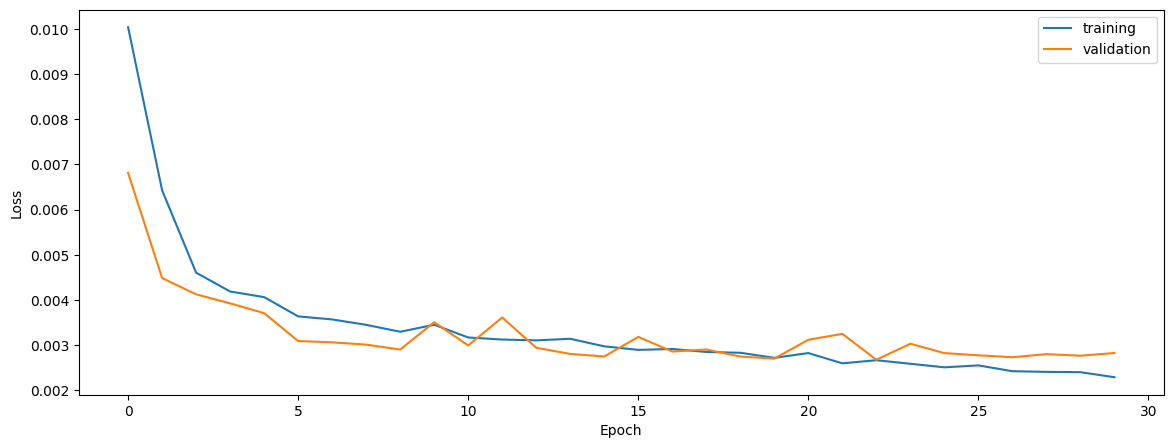

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8567528510428652
0.8305187776012408
0.8227901175998028


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8567133810155437
0.8427919161114845
0.8281395503036274


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8547508274607329
0.8404098879565449
0.8229799252811528


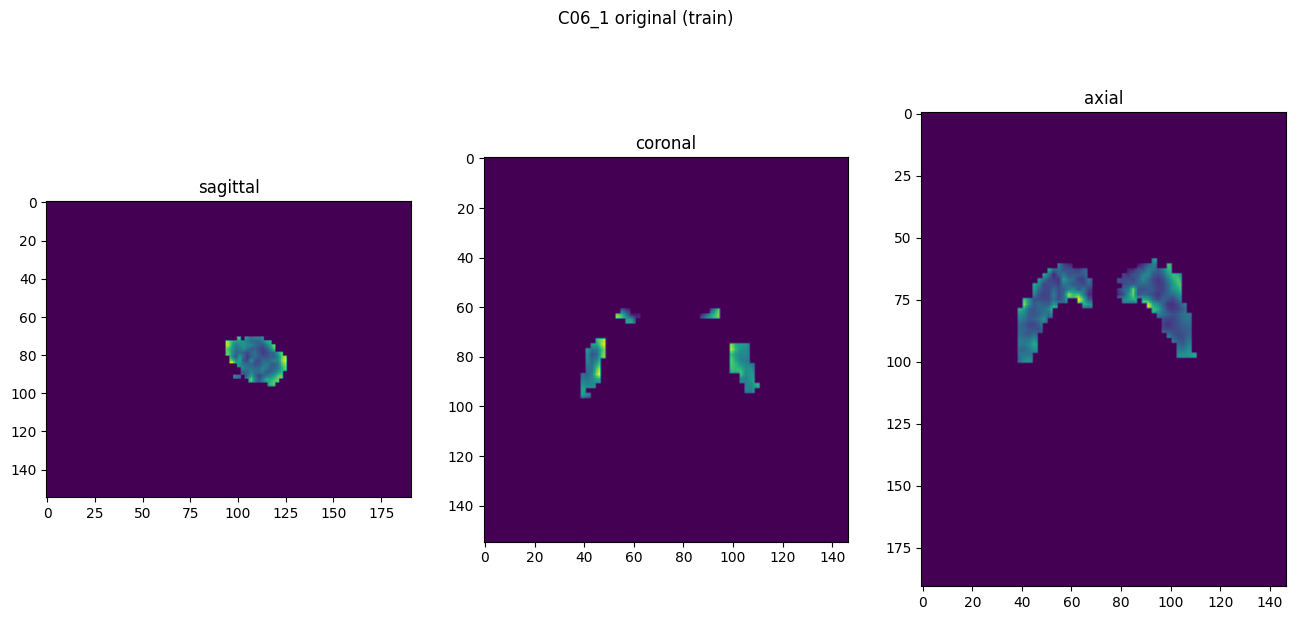

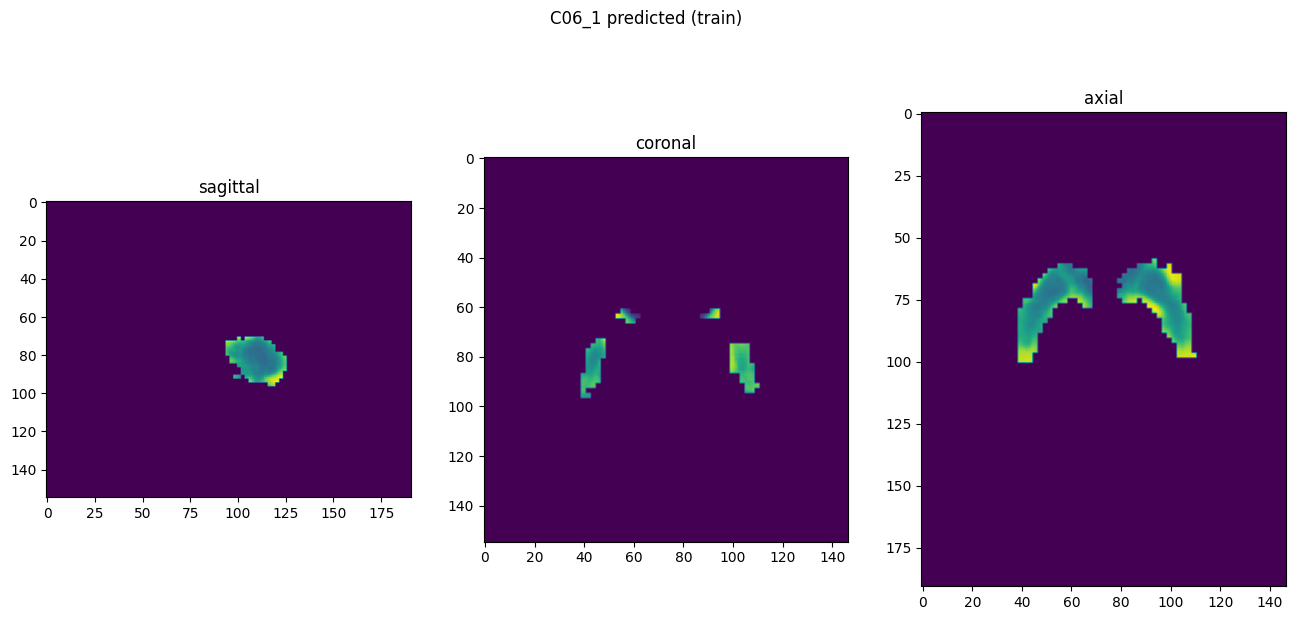

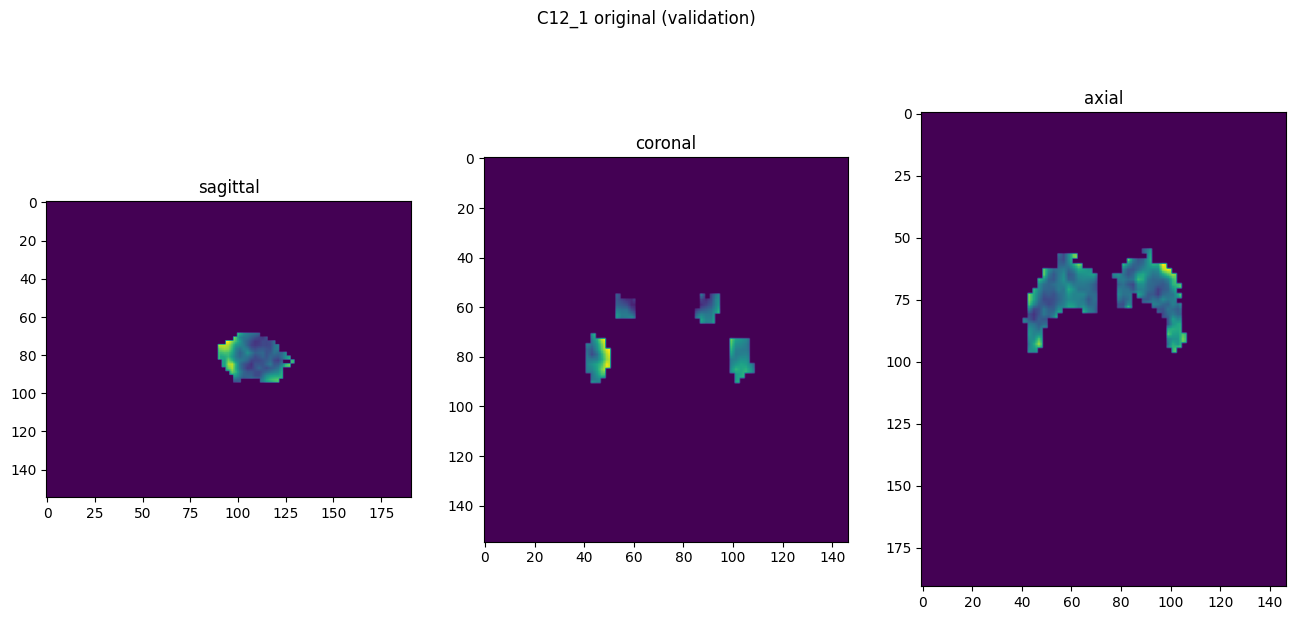

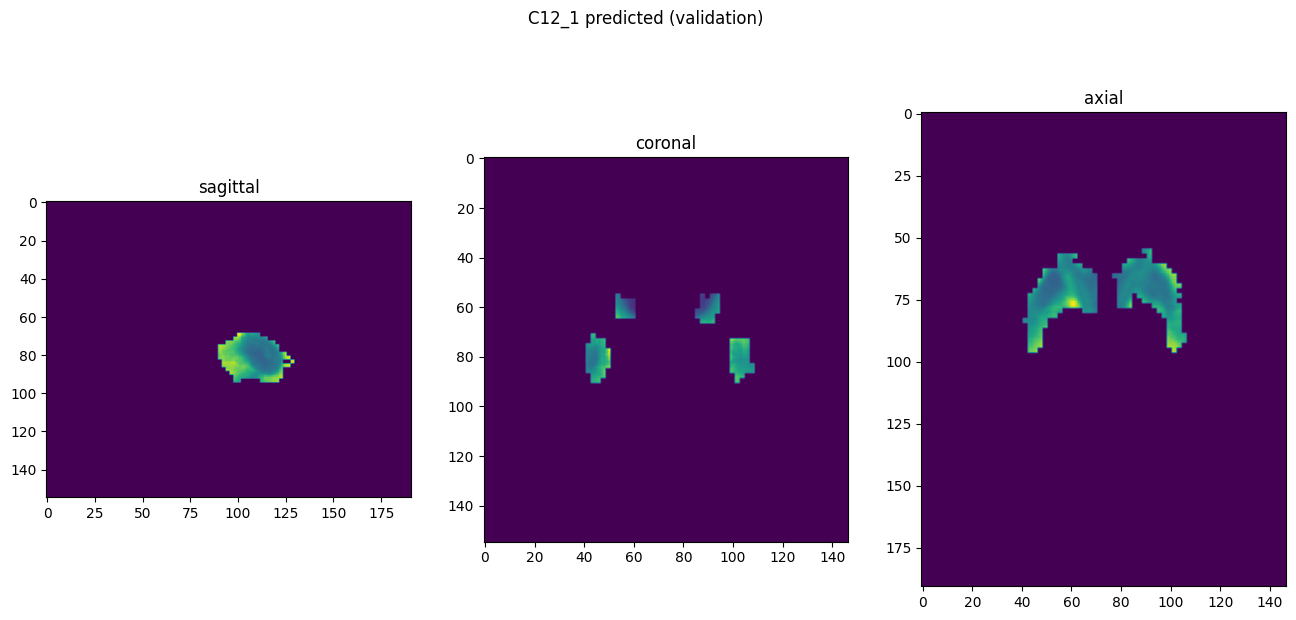

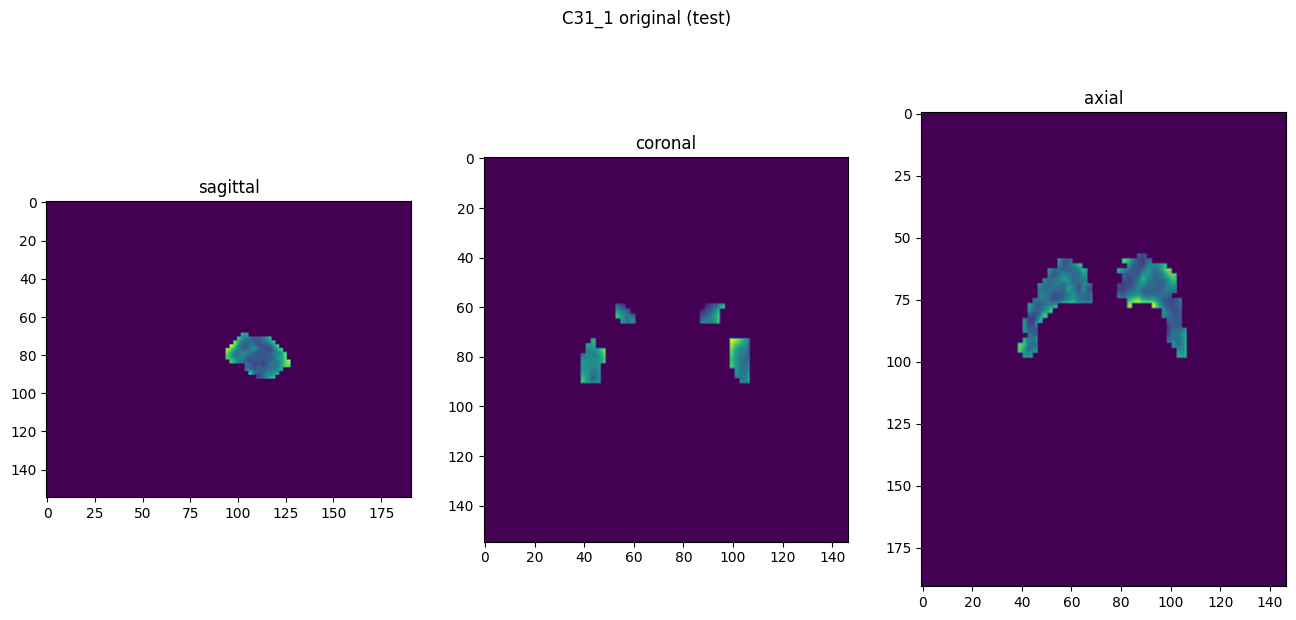

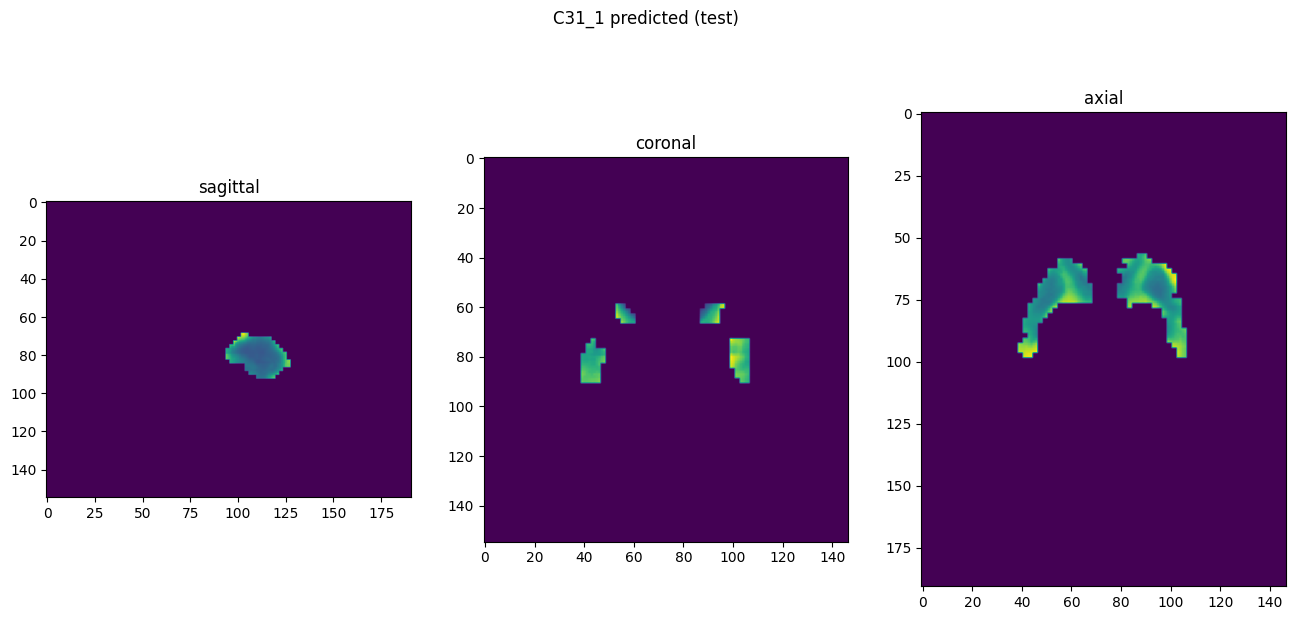

In [10]:
showResults(model, gen, threshold=None, background=False)